In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

[]


In [5]:
data_root = '/kaggle/input/aaaaaa/plates/plates'
print(os.listdir(data_root))

['test', 'train']


In [6]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 20/20 [00:00<00:00, 188.03it/s]


In [7]:
!ls train

cleaned  dirty


In [8]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [9]:
len(train_dataloader), len(train_dataset)

(4, 32)

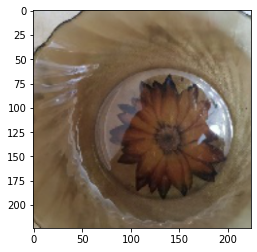

In [10]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

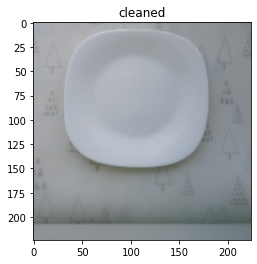

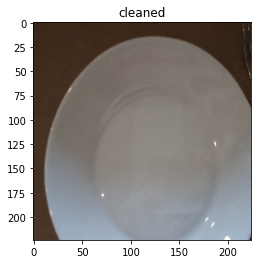

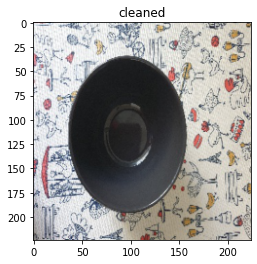

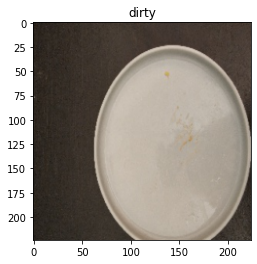

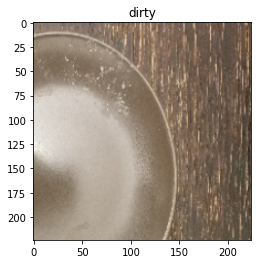

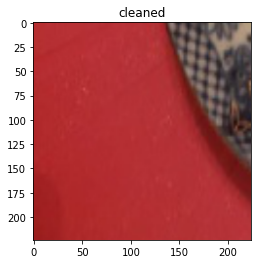

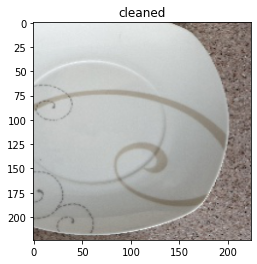

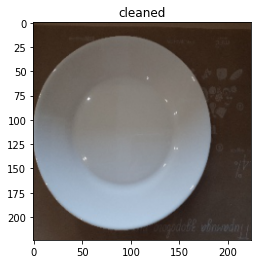

In [11]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [12]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [13]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [14]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

train Loss: 0.6957 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.6303 Acc: 0.7500
Epoch 1/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.6295 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

val Loss: 0.5224 Acc: 0.6250
Epoch 2/99:



100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

train Loss: 0.7379 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.5383 Acc: 0.7500
Epoch 3/99:



100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

train Loss: 0.6030 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

val Loss: 0.4508 Acc: 0.8750
Epoch 4/99:



100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

train Loss: 0.4967 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

val Loss: 0.5001 Acc: 0.7500
Epoch 5/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.5487 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

val Loss: 0.4475 Acc: 0.7500
Epoch 6/99:



100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

train Loss: 0.4868 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

val Loss: 0.4387 Acc: 0.7500
Epoch 7/99:



100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

train Loss: 0.4741 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.4399 Acc: 0.7500
Epoch 8/99:



100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

train Loss: 0.4237 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

val Loss: 0.4265 Acc: 0.7500
Epoch 9/99:



100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

train Loss: 0.4727 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

val Loss: 0.4118 Acc: 0.7500
Epoch 10/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.4603 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.4037 Acc: 0.7500
Epoch 11/99:



100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

train Loss: 0.4652 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

val Loss: 0.4044 Acc: 0.7500
Epoch 12/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.4356 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.4039 Acc: 0.7500
Epoch 13/99:



100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

train Loss: 0.3967 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.4097 Acc: 0.7500
Epoch 14/99:



100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

train Loss: 0.5017 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

val Loss: 0.4008 Acc: 0.7500
Epoch 15/99:



100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

train Loss: 0.4288 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

val Loss: 0.3980 Acc: 0.7500
Epoch 16/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.5431 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

val Loss: 0.3961 Acc: 0.8750
Epoch 17/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.5379 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.4027 Acc: 0.7500
Epoch 18/99:



100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

train Loss: 0.5179 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.4038 Acc: 0.7500
Epoch 19/99:



100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

train Loss: 0.4819 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.4001 Acc: 0.7500
Epoch 20/99:



100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

train Loss: 0.4452 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

val Loss: 0.4121 Acc: 0.7500
Epoch 21/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.4393 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.4058 Acc: 0.7500
Epoch 22/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.4808 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

val Loss: 0.4127 Acc: 0.7500
Epoch 23/99:



100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

train Loss: 0.4240 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

val Loss: 0.4118 Acc: 0.7500
Epoch 24/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.4165 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.4142 Acc: 0.7500
Epoch 25/99:



100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

train Loss: 0.5428 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

val Loss: 0.4065 Acc: 0.7500
Epoch 26/99:



100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

train Loss: 0.4568 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.3990 Acc: 0.8750
Epoch 27/99:



100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

train Loss: 0.4679 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

val Loss: 0.4019 Acc: 0.7500
Epoch 28/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.4581 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.4101 Acc: 0.8750
Epoch 29/99:



100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

train Loss: 0.4295 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.4028 Acc: 0.8750
Epoch 30/99:



100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

train Loss: 0.4646 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

val Loss: 0.4013 Acc: 0.8750
Epoch 31/99:



100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

train Loss: 0.5111 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

val Loss: 0.3878 Acc: 1.0000
Epoch 32/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.5022 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.3966 Acc: 0.8750
Epoch 33/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.3860 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

val Loss: 0.3926 Acc: 1.0000
Epoch 34/99:



100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

train Loss: 0.4702 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.3913 Acc: 1.0000
Epoch 35/99:



100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

train Loss: 0.4484 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

val Loss: 0.3950 Acc: 0.8750
Epoch 36/99:



100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

train Loss: 0.4200 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

val Loss: 0.3954 Acc: 1.0000
Epoch 37/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.4938 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.3999 Acc: 0.8750
Epoch 38/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.4592 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

val Loss: 0.3939 Acc: 0.8750
Epoch 39/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.4204 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

val Loss: 0.3853 Acc: 1.0000
Epoch 40/99:



100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

train Loss: 0.4180 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

val Loss: 0.3751 Acc: 1.0000
Epoch 41/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.4658 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

val Loss: 0.3787 Acc: 1.0000
Epoch 42/99:



100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

train Loss: 0.4487 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

val Loss: 0.3797 Acc: 0.8750
Epoch 43/99:



100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

train Loss: 0.4990 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.3890 Acc: 0.8750
Epoch 44/99:



100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

train Loss: 0.5254 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

val Loss: 0.3905 Acc: 1.0000
Epoch 45/99:



100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

train Loss: 0.4197 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

val Loss: 0.3919 Acc: 0.8750
Epoch 46/99:



100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

train Loss: 0.4613 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

val Loss: 0.3978 Acc: 0.7500
Epoch 47/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.4700 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

val Loss: 0.3968 Acc: 0.8750
Epoch 48/99:



100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

train Loss: 0.4216 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

val Loss: 0.3926 Acc: 0.8750
Epoch 49/99:



100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

train Loss: 0.4608 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.3993 Acc: 1.0000
Epoch 50/99:



100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

train Loss: 0.5389 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.3966 Acc: 0.8750
Epoch 51/99:



100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

train Loss: 0.4254 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

val Loss: 0.4036 Acc: 0.7500
Epoch 52/99:



100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

train Loss: 0.4838 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

val Loss: 0.3997 Acc: 0.7500
Epoch 53/99:



100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

train Loss: 0.4955 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

val Loss: 0.4007 Acc: 0.7500
Epoch 54/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.4586 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.4017 Acc: 0.7500
Epoch 55/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.5499 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

val Loss: 0.4068 Acc: 0.7500
Epoch 56/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.4507 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

val Loss: 0.4100 Acc: 0.7500
Epoch 57/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.4861 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

val Loss: 0.4051 Acc: 0.8750
Epoch 58/99:



100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

train Loss: 0.4944 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

val Loss: 0.4066 Acc: 0.8750
Epoch 59/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.3958 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

val Loss: 0.3978 Acc: 1.0000
Epoch 60/99:



100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

train Loss: 0.5541 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

val Loss: 0.3983 Acc: 1.0000
Epoch 61/99:



100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

train Loss: 0.4330 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.4031 Acc: 0.8750
Epoch 62/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.5023 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

val Loss: 0.3938 Acc: 0.8750
Epoch 63/99:



100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

train Loss: 0.4333 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

val Loss: 0.4048 Acc: 0.8750
Epoch 64/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.4398 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

val Loss: 0.4068 Acc: 0.7500
Epoch 65/99:



100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

train Loss: 0.4270 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

val Loss: 0.4049 Acc: 0.7500
Epoch 66/99:



100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

train Loss: 0.3782 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

val Loss: 0.3960 Acc: 0.7500
Epoch 67/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.4554 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.3967 Acc: 0.8750
Epoch 68/99:



100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

train Loss: 0.4871 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

val Loss: 0.3949 Acc: 0.7500
Epoch 69/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.5040 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

val Loss: 0.3842 Acc: 1.0000
Epoch 70/99:



100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

train Loss: 0.4074 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

val Loss: 0.3743 Acc: 1.0000
Epoch 71/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.5104 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

val Loss: 0.3761 Acc: 1.0000
Epoch 72/99:



100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

train Loss: 0.4694 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

val Loss: 0.3817 Acc: 1.0000
Epoch 73/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.4688 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.3911 Acc: 1.0000
Epoch 74/99:



100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

train Loss: 0.4594 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

val Loss: 0.3973 Acc: 0.7500
Epoch 75/99:



100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

train Loss: 0.3999 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

val Loss: 0.3948 Acc: 1.0000
Epoch 76/99:



100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

train Loss: 0.5082 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

val Loss: 0.4010 Acc: 0.7500
Epoch 77/99:



100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

train Loss: 0.4589 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

val Loss: 0.4003 Acc: 0.7500
Epoch 78/99:



100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

train Loss: 0.4715 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

val Loss: 0.4023 Acc: 0.7500
Epoch 79/99:



100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

train Loss: 0.4591 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

val Loss: 0.4038 Acc: 0.7500
Epoch 80/99:



100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

train Loss: 0.4809 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.4119 Acc: 0.7500
Epoch 81/99:



100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

train Loss: 0.4221 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

val Loss: 0.4065 Acc: 0.7500
Epoch 82/99:



100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

train Loss: 0.4339 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.4023 Acc: 0.7500
Epoch 83/99:



100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

train Loss: 0.4757 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

val Loss: 0.3946 Acc: 0.8750
Epoch 84/99:



100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

train Loss: 0.4514 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

val Loss: 0.3942 Acc: 0.8750
Epoch 85/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.5257 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

val Loss: 0.3969 Acc: 0.8750
Epoch 86/99:



100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

train Loss: 0.4015 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

val Loss: 0.4100 Acc: 0.7500
Epoch 87/99:



100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

train Loss: 0.5085 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

val Loss: 0.4107 Acc: 0.7500
Epoch 88/99:



100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

train Loss: 0.4163 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

val Loss: 0.4081 Acc: 0.8750
Epoch 89/99:



100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

train Loss: 0.4185 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.3963 Acc: 0.8750
Epoch 90/99:



100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

train Loss: 0.4518 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

val Loss: 0.3993 Acc: 0.7500
Epoch 91/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.4743 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

val Loss: 0.3819 Acc: 0.8750
Epoch 92/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.4713 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

val Loss: 0.3781 Acc: 0.8750
Epoch 93/99:



100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

train Loss: 0.4287 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

val Loss: 0.3872 Acc: 0.8750
Epoch 94/99:



100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

train Loss: 0.3895 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

val Loss: 0.3935 Acc: 0.8750
Epoch 95/99:



100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

train Loss: 0.4521 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

val Loss: 0.4006 Acc: 0.7500
Epoch 96/99:



100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

train Loss: 0.4756 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

val Loss: 0.4011 Acc: 0.7500
Epoch 97/99:



100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

train Loss: 0.4757 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.4103 Acc: 0.7500
Epoch 98/99:



100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

train Loss: 0.4575 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

val Loss: 0.4151 Acc: 0.7500
Epoch 99/99:



100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

train Loss: 0.4844 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

val Loss: 0.4109 Acc: 0.7500


In [15]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'un'))

'test/un'

In [17]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [18]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [19]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


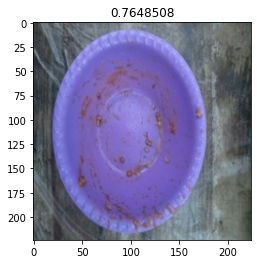

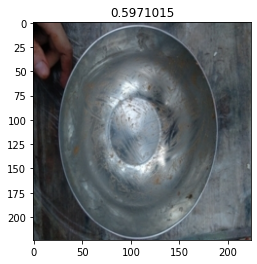

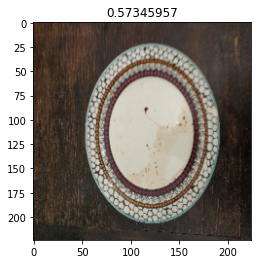

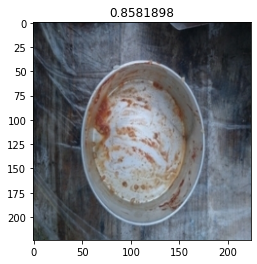

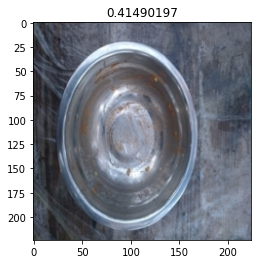

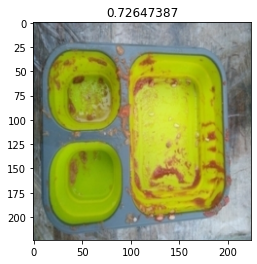

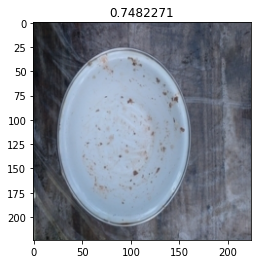

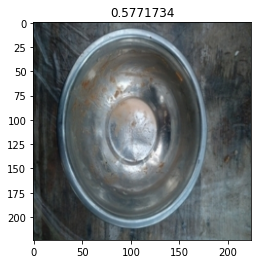

In [20]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [29]:
submission_df = pd.DataFrame.from_dict({'id': [path[-8:-4] for path in test_img_paths], 'label': test_predictions})

In [30]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,cleaned
0005,dirty


In [32]:
submission_df.to_csv('s.csv')